In [62]:
import math
import time
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.analysis import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin, obtain_max_in_dimension
from sklearn.linear_model import LinearRegression
from sbi.analysis import pairplot
from stg_energy.common import get_labels_8pt, generate_labels_for_pairplot
import matplotlib.patheffects as pe

# Figure 3

In [63]:
pd.options.display.max_columns = 999

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_B_lin = "../svg/panel_b_lin.svg"
PANEL_B_raw = "../svg/panel_b_raw.svg"
PANEL_C = "../svg/panel_c.svg"
PANEL_D = "../svg/panel_d.svg"
PANEL_E1 = "../svg/panel_e1.svg"
PANEL_E2 = "../svg/panel_e2.svg"
PANEL_F1 = "../svg/panel_f1.svg"
PANEL_F1_raw = "../svg/panel_f1_raw.svg"
PANEL_F2 = "../svg/panel_f2.svg"
PANEL_G1 = "../svg/panel_g1.svg"
PANEL_G2 = "../svg/panel_g2.svg"
PANEL_H1 = "../svg/panel_h1.svg"
PANEL_H2 = "../svg/panel_h2.svg"
PANEL_I1 = "../svg/panel_i1.svg"
PANEL_I2 = "../svg/panel_i2.svg"
PANEL_Synapses_reduction = "../svg/panel_synapses_reduction.svg"

PANEL_supp_EV1 = "../svg/panel_supp_ev1.svg"
PANEL_supp_EV2 = "../svg/panel_supp_ev2.svg"
PANEL_supp_EV3 = "../svg/panel_supp_ev3.svg"

PANEL_supp_shift1 = "../svg/panel_supp_shift1.svg"
PANEL_supp_shift2 = "../svg/panel_supp_shift2.svg"
PANEL_supp_shift3 = "../svg/panel_supp_shift3.svg"
PANEL_supp_shift4 = "../svg/panel_supp_shift4.svg"
PANEL_supp_shift5 = "../svg/panel_supp_shift5.svg"
PANEL_supp_shift6 = "../svg/panel_supp_shift6.svg"
PANEL_supp_shift7 = "../svg/panel_supp_shift7.svg"

PANEL_supp_performance1 = "../svg/panel_supp_performance1.svg"
PANEL_supp_performance2 = "../svg/panel_supp_performance2.svg"
PANEL_supp_performance3 = "../svg/panel_supp_performance3.svg"

PANEL_supp_synapses1 = "../svg/panel_supp_synapses1.svg"
PANEL_supp_synapses2 = "../svg/panel_supp_synapses2.svg"
PANEL_supp_synapses3 = "../svg/panel_supp_synapses3.svg"

PANEL_NEW_A = "../svg/panel_new_a_inkscape.svg"

PANEL_NEW_F1 = "../svg/panel_new_f1.svg"
PANEL_NEW_F2 = "../svg/panel_new_f2.svg"

PANEL_NEW_G1 = "../svg/panel_new_g1.svg"
PANEL_NEW_G2 = "../svg/panel_new_g2.svg"
PANEL_NEW_supp_params_11 = "../svg/PANEL_NEW_supp_params_11.svg"
PANEL_NEW_supp_params_12 = "../svg/PANEL_NEW_supp_params_12.svg"
PANEL_NEW_supp_params_21 = "../svg/PANEL_NEW_supp_params_21.svg"
PANEL_NEW_supp_params_22 = "../svg/PANEL_NEW_supp_params_22.svg"

PANEL_MECH_KD_A = "../svg/panel_mech_kd_a_new.svg"
PANEL_MECH_KD_B = "../svg/panel_mech_kd_b_new.svg"
PANEL_MECH_KD_C = "../svg/panel_mech_kd_c_new.svg"
PANEL_MECH_KD_D = "../svg/panel_mech_kd_d_new.svg"
PANEL_MECH_KD_E = "../svg/panel_mech_kd_e_new.svg"
PANEL_MECH_KD_F = "../svg/panel_mech_kd_f_new.svg"
PANEL_MECH_KD_voltage = "../svg/panel_mech_kd_voltage_new.svg"
PANEL_lin_reg = "../svg/panel_lin_reg.svg"
PANEL_act_sub = "../svg/panel_act_sub.svg"

### Load experimental data

In [66]:
prior_11 = create_prior()

In [67]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

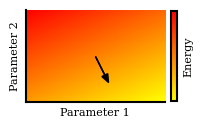

In [68]:
import stg_energy.fig3_active_subspaces.viz as viz

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.active_subspace_sketch()
    plt.savefig(PANEL_B_raw, facecolor='None', transparent=False)
    

### Simulate 10 samples and keep track of the energy consumption of each trace

In [69]:
def simulator(p_with_s):
    circuit_params = np.asarray([p_with_s[:-1]])
    theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
    out_target = simulate(
        theta_pd.loc[0], seed=int(p_with_s[-1]), track_energy=True, track_currents=True
    )
    all_energies = energy_of_membrane(out_target)
    synaptic_energies = energy_of_synapse(out_target)

    summed_energy_each_current = np.sum(all_energies, axis=2)
    summed_energy_synapses = np.sum(synaptic_energies, axis=1)
    summed_energy_total = np.sum(all_energies) + np.sum(synaptic_energies)
    fraction_of_each_current = summed_energy_each_current / summed_energy_total
    fraction_of_synapse = summed_energy_synapses / summed_energy_total
    return (fraction_of_each_current, fraction_of_synapse)

In [70]:
# torch.manual_seed(0)
# params_with_seeds = np.concatenate(
#     (
#         theta_np[:200],
#         seeds[:200][
#             None,
#         ].T,
#     ),
#     axis=1,
# )
# simulation_outputs = list(map(simulator, params_with_seeds))
simulation_outputs = np.load("../../../results/simulation_data_Tube_MLslurm_cluster/twohundred_predictives_individual_currents.npy", allow_pickle=True)

In [71]:
# np.save("../../../results/simulation_data_Tube_MLslurm_cluster/twohundred_predictives_individual_currents.npy", simulation_outputs)

In [72]:
all_e_cur = []
all_e_syn = []
for so in simulation_outputs:
    e_cur, e_syn = so
    all_e_cur.append(e_cur)
    all_e_syn.append(e_syn)

all_e_cur = np.asarray(all_e_cur)
all_e_syn = np.asarray(all_e_syn)
fractions = np.mean(all_e_cur, axis=0)
synapse_fractions = np.mean(all_e_syn, axis=0)

In [73]:
summed_energy_synapses = np.sum(all_e_syn, axis=1)

In [74]:
summed_energy_membrane = np.sum(np.sum(all_e_cur, axis=1), axis=1)

In [75]:
fraction_between_them = summed_energy_synapses / (summed_energy_membrane + summed_energy_synapses)

In [76]:
print("Fraction of energy consumed by synapses:   ", np.mean(fraction_between_them)*100, "%")

Fraction of energy consumed by synapses:    0.07815773482273314 %


In [77]:
current_fractions = fractions.T.flatten()
all_fractions = np.concatenate((current_fractions, synapse_fractions))
all_fractions /= np.linalg.norm(all_fractions)

###  Fit regression net for total energy

In [78]:
import sys
sys.path.append("home/michael/Documents/sbi/sbi/utils/user_input_checks_utils")

In [79]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [80]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = 'cpu'

/home/michael/Documents/STG_energy_sbi/sbi/inference/posteriors/base_posterior.py:1089: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False` `self._sample_with = rejection`
  warn(warning_description + warning_msg)


In [81]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

In [82]:
energies = x["energies"]

In [83]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [84]:
num_test = 1000

theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [85]:
train_energy = torch.as_tensor(
    torch.sum(energies_tt[num_test:], dim=1).unsqueeze(1), dtype=torch.float32
)
test_energy = torch.as_tensor(
    torch.sum(energies_tt[:num_test], dim=1).unsqueeze(1), dtype=torch.float32
)

In [86]:
posterior._sample_with = "rejection"

### Linear regression

In [87]:
from pyloric import create_prior

In [88]:
prior = create_prior()

In [89]:
num_test = 500

test_params = theta_np[:num_test]
train_params = theta_np[num_test:]
mean_params = prior.numerical_prior.mean.numpy()
std_params = prior.numerical_prior.stddev.numpy()

mean_params = obtain_max_in_dimension(mean_params)
std_params = obtain_max_in_dimension(std_params)
# mean_params[8:16] = mean_params[:8]
# mean_params[16:24] = mean_params[:8]
# std_params[8:16] = std_params[:8]
# std_params[16:24] = std_params[:8]

# mean_params[:8] = mean_params[8:16]
# mean_params[:8] = mean_params[8:16]
# std_params[16:24] = std_params[8:16]
# std_params[16:24] = std_params[8:16]

# mean_params[:8] = mean_params[16:24]
# mean_params[:8] = mean_params[16:24]
# std_params[8:16] = std_params[16:24]
# std_params[8:16] = std_params[16:24]

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

In [90]:
train_energy_ABPD = torch.sum(torch.as_tensor(energies.to_numpy())[num_test:], dim=1).unsqueeze(1)
test_energy_ABPD = torch.sum(torch.as_tensor(energies.to_numpy())[:num_test], dim=1).unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

In [91]:
regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

In [92]:
# np.save("../../../results/regression_nets/linear_regression.npy", fitted_reg)
# np.save("../../../results/regression_nets/linear_regression_theta_mean.npy", mean_params)
# np.save("../../../results/regression_nets/linear_regression_theta_std.npy", std_params)
# np.save("../../../results/regression_nets/linear_regression_x_mean.npy", mean_energy)
# np.save("../../../results/regression_nets/linear_regression_x_std.npy", std_energy)

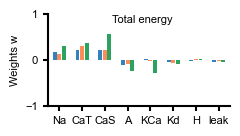

In [93]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        torch.as_tensor(coeff)[0],
        ylim=[-1, 1.0],
        figsize=(2.35, 1.2),
        ylabel='Weights w',
        plot_labels=True,
        legend=False,
        title='Total energy',
        yticks=[-1, 0, 1]
    )
    plt.savefig(PANEL_C, facecolor="None", transparent=False)
    plt.show()

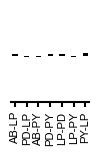

In [94]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        deepcopy(torch.as_tensor(coeff))[:, -7:], ylim=[-1,1], figsize=(1., 1.2), ylabel=None, color="k", width_multiplier=0.5
    )
    plt.savefig(PANEL_supp_synapses1, facecolor="None", transparent=False)
    plt.show()

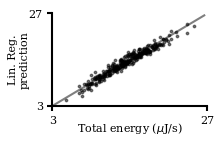

In [95]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.2))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy.numpy() + mean_energy.numpy()
    ax.scatter(x=unnorm_x.numpy()/10/1000, y=unnorm_y/10/1000, s=3, color="k", alpha=0.5)
    ax.plot([3, 26.5], [3, 26.5], "k", alpha=0.5)
    ax.set_xlabel("Total energy ($\mu$J/s)", labelpad=-4)
    ax.set_ylabel("Lin. Reg.\nprediction", labelpad=-1)
    ax.set_xticks([3, 27])
    ax.set_yticks([3, 27])
    ax.set_xlim([3, 27])
    ax.set_ylim([3, 27])
    plt.savefig(PANEL_supp_performance1, facecolor='None', transparent=False)

## Which parameters affect energy, which parameters influence energy?

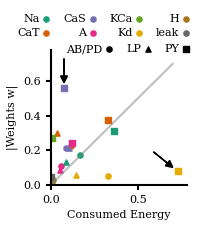

In [96]:
eigenvector = coeff[0]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.scatter_sensitivity_consumption(all_fractions, eigenvector)
    plt.savefig(PANEL_D, facecolor="None", transparent=False)

# Why does Kd not influence energy?

### Doubling Na leads to twice as high effective conductances

In [105]:
t = np.arange(0, 11000, 0.025)

In [98]:
custom_stats = {
    "plateau_durations": True,
    "num_bursts": True,
    "num_spikes": True,
    "energies": True,
    "energies_per_burst": True,
    "energies_per_spike": True,
    "pyloric_like": True,
}

In [99]:
index = 2
out_target_base = simulate(theta.loc[index], seed=int(seeds[index]), track_energy=True, track_currents=True)
summstats_base = summary_stats(out_target_base, stats_customization=custom_stats)

In [100]:
print("Energy consumption of PY:              ", int(summstats_base["energies"]["PY"].loc[0]))
print("Num spikes of PY:                      ", int(summstats_base["num_spikes"]["PY"].loc[0]))
print("Energy consumption per spike of PY:    ", int(summstats_base["energies_per_spike"]["PY"].loc[0]))

Energy consumption of PY:               30661
Num spikes of PY:                       162
Energy consumption per spike of PY:     185


In [101]:
perturbed_theta = deepcopy(theta.loc[index])
perturbed_theta["PY"]["Kd"] += perturbed_theta["PY"]["Kd"] * 0.5

In [102]:
out_target = simulate(perturbed_theta, seed=int(seeds[index]), track_energy=True, track_currents=True)
summstats = summary_stats(out_target, stats_customization=custom_stats)

In [103]:
print("Energy consumption of PY:              ", int(summstats["energies"]["PY"].loc[0]))
print("Num spikes of PY:                      ", int(summstats["num_spikes"]["PY"].loc[0]))
print("Energy consumption per spike of PY:    ", int(summstats["energies_per_spike"]["PY"].loc[0]))

Energy consumption of PY:               25197
Num spikes of PY:                       139
Energy consumption per spike of PY:     176


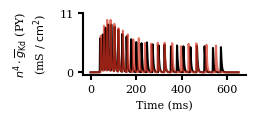

In [106]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.1, 0.8))
    _ = ax.plot(t[:91500-65500], out_target_base["membrane_conds"][2, 5, 70500:96500], c="k")
    _ = ax.plot(t[:91500-65500], out_target["membrane_conds"][2, 5, 70500:96500], alpha=0.7, c="#d7301f")
    ax.set_ylabel("$n^4 \cdot \overline{g}_{\mathrm{Kd}}$ (PY)\n(mS / $\mathrm{cm}^2$)", labelpad=6.5)
    ax.set_xlabel("Time (ms)")
    
    ax.set_ylim([-0.45, 11])
    ax.set_yticks([0, 11])
    ax.set_xticks([0, 200, 400, 600])
    plt.savefig(PANEL_MECH_KD_B, facecolor="None", transparent=True)

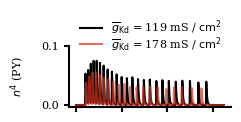

In [134]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.1, 0.8))
    _ = ax.plot(t[:91500-65500], out_target_base["n_Kd"][2, 70500:96500]**4, c="k") # 66000:91000
    _ = ax.plot(t[:91500-65500], out_target["n_Kd"][2, 70500:96500]**4, alpha=0.7, c="#d7301f")
    ax.set_ylabel("$n^4$ (PY)", labelpad=10)
#     ax.set_xlabel("Time (ms)")
    ax.set_xticks([])
    ax.legend(
        [
            "$\overline{g}_{\mathrm{Kd}}$"+f" = {int(theta.loc[index]['PY']['Kd'])}" + " mS / $\mathrm{cm}^2$", 
            "$\overline{g}_{\mathrm{Kd}}$"+f" = {int(perturbed_theta['PY']['Kd'])}" + " mS / $\mathrm{cm}^2$"
        ], 
        loc=(0.04, 0.8), 
        labelspacing=-0.2
    )
    ax.set_xticks([0, 200, 400, 600])
    ax.set_xticklabels([])
    ax.set_ylim([-0.0035, 0.1])
    ax.set_yticks([0, 0.1])
    plt.savefig(PANEL_MECH_KD_D, facecolor="None", transparent=True)

# Energy per spike

In [48]:
all_energies_per_spike_ABPD = x["energies_per_spike"]["PY"].to_numpy() / 1000

In [49]:
all_e_per_spike_ABPD = torch.as_tensor(all_energies_per_spike_ABPD)
train_energy_ABPD = all_e_per_spike_ABPD[num_test:].unsqueeze(1)
test_energy_ABPD = all_e_per_spike_ABPD[:num_test].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

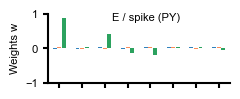

In [50]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        torch.as_tensor(coeff)[0],
        ylim=[-1, 1.0],
        figsize=(2.35, 0.9),
        ylabel="Weights w",
        plot_labels=False,
        legend=False,
        title='E / spike (PY)',
        title_x_offset=0,
    )
    plt.savefig(PANEL_E1, facecolor="None", transparent=True)
    plt.show()

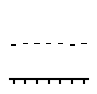

In [51]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        deepcopy(torch.as_tensor(coeff))[:, -7:], ylim=[-1,1], figsize=(1., 0.9), ylabel=None, color="k", plot_labels=False, width_multiplier=0.5
    )
    plt.savefig(PANEL_supp_synapses2, facecolor="None", transparent=False)
    plt.show()

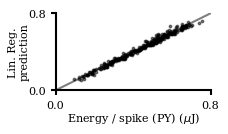

In [52]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy.numpy() + mean_energy.numpy()
    ax.scatter(x=unnorm_x.numpy(), y=unnorm_y, s=3, color="k", alpha=0.5)
    ax.plot([0, 0.8], [0, 0.8], "k", alpha=0.5)
    ax.set_xlabel("Energy / spike (PY) ($\mu$J)", labelpad=0)
    ax.set_ylabel("Lin. Reg.\nprediction", labelpad=-1)
    ax.set_xticks([0, 0.8])
    ax.set_yticks([0, 0.8])
    ax.set_xlim([0, 0.8])
    ax.set_ylim([0, 0.8])
    plt.savefig(PANEL_supp_performance2, facecolor='None', transparent=False)

## Number of spikes

In [53]:
numSpikesPerBurst = x["num_spikes"]["PY"].to_numpy() / x["num_bursts"]["PY"].to_numpy()

In [54]:
numSpikesPerBurst = torch.as_tensor(numSpikesPerBurst)
train_energy_ABPD = numSpikesPerBurst[num_test:].unsqueeze(1)
test_energy_ABPD = numSpikesPerBurst[:num_test].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

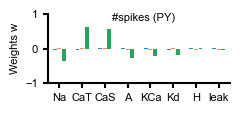

In [55]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        torch.as_tensor(coeff)[0],
        ylim=[-1, 1.0],
        figsize=(2.35, 0.9),
        ylabel="Weights w",
        plot_labels=True,
        legend=False,
        legend_y_offset=0.3,
        title='#spikes (PY)',
        title_x_offset=0,
        yticks=[-1, 0, 1]
    )
    plt.savefig(PANEL_E2, facecolor="None", transparent=True)
    plt.show()

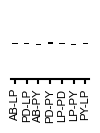

In [56]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        deepcopy(torch.as_tensor(coeff))[:, -7:], ylim=[-1,1], figsize=(1., 0.9), ylabel=None, color="k", plot_labels=True, width_multiplier=0.5
    )
    plt.savefig(PANEL_supp_synapses3, facecolor="None", transparent=False)
    plt.show()

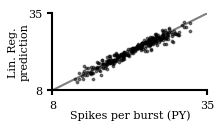

In [57]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy.numpy() + mean_energy.numpy()
    ax.scatter(x=unnorm_x.numpy(), y=unnorm_y, s=3, color="k", alpha=0.5)
    ax.plot([8, 35], [8, 35], "k", alpha=0.5)
    ax.set_xlabel("Spikes per burst (PY)", labelpad=0)
    ax.set_ylabel("Lin. Reg.\nprediction", labelpad=-1)
    ax.set_xticks([8, 35])
    ax.set_yticks([8, 35])
    ax.set_xlim([8, 35])
    ax.set_ylim([8, 35])
    plt.savefig(PANEL_supp_performance3, facecolor='None', transparent=False)

## Assemble figure

In [58]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [144]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "9.4cm",

    Panel(
          SVG(PANEL_act_sub).scale(svg_scale).move(0, 0*factor_svg),
        Text("a", -4.0*factor_svg, 1.8*factor_svg, **kwargs_text),
          Text("w", 19.3*factor_svg, 14.9*factor_svg, **kwargs_text8pt),
    ).move(4*factor_svg, 0.7*factor_svg),

    Panel(
          SVG(PANEL_supp_performance1).scale(svg_scale).move(0, 0*factor_svg),
          Text("b", -1.2*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(42.2*factor_svg, 0.0*factor_svg),
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0, 0*factor_svg),
          Text("c", -1.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(85.0*factor_svg, 0*factor_svg),
    Panel(
          SVG(PANEL_supp_synapses1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(124.0*factor_svg, 0.7*factor_svg),
    Panel(
          SVG("../svg/panel_legend_2x2.svg").scale(svg_scale).move(0, 0*factor_svg),
    ).move(125.5*factor_svg, 2.4*factor_svg),
           
    Panel(
          SVG(PANEL_D).scale(svg_scale).move(0, 0*factor_svg),
          Text("d", 0.5*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(-0.5*factor_svg, 27.0*factor_svg),
           
    Panel(
          SVG(PANEL_MECH_KD_D).scale(svg_scale).move(0, 0*factor_svg),
          Text("e", 0.8*factor_svg, 4.1*factor_svg, **kwargs_text),
    ).move(40.2*factor_svg, 25.4*factor_svg),

    Panel(
          SVG(PANEL_MECH_KD_B).scale(svg_scale).move(0, 0*factor_svg),
    ).move(38.4*factor_svg, 44.9*factor_svg),

    Panel(
          SVG(PANEL_E1).scale(svg_scale).move(0, 0*factor_svg),
          Text("f", -1*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(85.0*factor_svg, 28.0*factor_svg),
    Panel(
          SVG(PANEL_supp_synapses2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(124.0*factor_svg, 28.7*factor_svg),

    Panel(
          SVG(PANEL_E2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(85*factor_svg, 43.5*factor_svg),
    Panel(
          SVG(PANEL_supp_synapses3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(124.0*factor_svg, 44.2*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_2x.svg")
svg('../fig/fig3_2x.svg')

### Build appendix

In [60]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.0cm",

    Panel(
          SVG(PANEL_supp_performance2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_performance3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(45*factor_svg, 0*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_supp1.svg")
svg('../fig/fig3_supp1.svg')